# Taylor-Green vortex problem in three-dimensional space

By Fabian Fritz

In [1]:
from jax import jit, vmap, grad
from jax_md import space, partition

import jax.numpy as jnp
import numpy as onp

from functools import partial, namedtuple

In [2]:
# from jax.config import config

# NOTE uncomment for enabling double-precision, see https://github.com/google/jax#current-gotchas
# config.update("jax_enable_x64", True)

# NOTE uncomment for enabling CPU computaitons
# config.update('jax_platform_name', 'cpu')

## Kernel Function

In [3]:
class Kernel:
    """The kernel object is a polymorphic base class for all derived kernels."""

    def __init__(self, h, dim):
        self._dim = dim
        self._h = h
        self._one_over_h = 1.0 / h

    def w(self, r):
        """Evaluates the kernel at the radial coordinate r."""
        return self._w(r)

    def grad_w(self, r):
        """Evaluates the kernel gradient at the radial coordinate r by utilization of automatic differentation."""
        return grad(self.w)(r)


class QuinticKernel(Kernel):
    """The quintic kernel function of Morris."""

    def __init__(self, h, dim = 3):
        Kernel.__init__(self, h, dim)
        self._normalized_cutoff = 3.0
        self.cutoff = self._normalized_cutoff * h
        self._sigma_1d = 120 * self._one_over_h
        self._sigma_2d = 7.0 / 478.0 / jnp.pi * self._one_over_h * self._one_over_h
        self._sigma_3d = 3.0 / 359.0 / jnp.pi * self._one_over_h * self._one_over_h * self._one_over_h
        self._sigma = jnp.where(dim == 3, self._sigma_3d, jnp.where(dim == 2, self._sigma_2d, self._sigma_1d))

    def _w(self, r):

        q = r * self._one_over_h

        q1 = jnp.maximum(0.0, 1.0 - q)
        q2 = jnp.maximum(0.0, 2.0 - q)
        q3 = jnp.maximum(0.0, 3.0 - q)

        return self._sigma * (q3 * q3 * q3 * q3 * q3 - 6.0 * q2 * q2 * q2 * q2 * q2 + 15.0 * q1 * q1 * q1 * q1 * q1)
    

## Time Integration Scheme

In [4]:
State = namedtuple("state", ['r', 'rho', 'u', 'v', 'dudt', 'dvdt', 'mass', 'dynamic_viscosity'])


@partial(jit, static_argnums = (3, 4))
def density_summation(mass, r, neighbors, kernel_fn, displacement_fn):

    r_neighbors = r[neighbors.idx]
    dr_neighbors = vmap(vmap(displacement_fn, (None, 0)))(r, r_neighbors)

    mask_neighbors = (neighbors.idx < dr_neighbors.shape[0])

    @partial(jit, static_argnums = 1)
    def _kernel_sum(dr, kernel_fn):
        """Returns the kernel summation."""
        d = space.distance(dr)
        
        return jnp.where(d < kernel_fn.cutoff, kernel_fn.w(d), 0.0)
    
    kernel_sum = partial(_kernel_sum, kernel_fn=kernel_fn)
    kernel_sum = vmap(vmap(kernel_sum))(dr_neighbors)
    
    return mass * jnp.sum(kernel_sum, where = mask_neighbors, axis = 1)

@partial(jit, static_argnums = (7, 8, 9))
def update_time_derivatives(r, rho, u, v, mass, eta, neighbors, kernel_fn, displacement_fn, pressure_fn):

    @jit
    def arithmetic_mean(a: float, b: float) -> float:
        return 0.5 * (a + b)

    @jit
    def harmonic_mean(a: float, b: float) -> float:
        return 2.0 * a * b / (a + b + jnp.finfo(float).eps)

    @jit
    def weighted_volume(rho_i: float, rho_j: float, m_i: float, m_j: float) -> float:
        v_i = (m_i / rho_i)
        v_j = (m_j / rho_j)

        return (v_i * v_i + v_j * v_j) / m_i

    r_neighbors = r[neighbors.idx]
    dr_neighbors = vmap(vmap(displacement_fn, (None, 0)))(r, r_neighbors)
    mask_neighbors = (neighbors.idx < dr_neighbors.shape[0])
    
    rho_neighbors = rho[neighbors.idx * mask_neighbors]
    u_neighbors = u[neighbors.idx * mask_neighbors]
    v_neighbors = v[neighbors.idx * mask_neighbors]
    mass_neighbors = mass[neighbors.idx * mask_neighbors]
    eta_neighbors = eta[neighbors.idx * mask_neighbors]
    
    p = vmap(pressure_fn)(rho)
    p_neighbors = p[neighbors.idx * mask_neighbors]

    @jit
    def update_dudt():

        @jit
        def transport_stress(rho: float, u, v):
            """Return the transport stress tensor."""
            return jnp.outer(rho * u, v - u)    

        @partial(jit, static_argnums=(13))
        def _acceleration_fn(r_ij, rho_i, rho_j, u_i, u_j, v_i, v_j, m_i, m_j, eta_i, eta_j, p_i, p_j, kernel_fn):
            d = space.distance(r_ij)

            p_ij = (rho_j * p_i + rho_i * p_j) / (rho_i + rho_j)
            eta_ij = harmonic_mean(eta_i, eta_j)

            return jnp.where(d < kernel_fn.cutoff, weighted_volume(rho_i, rho_j, m_i, m_j) * (-p_ij * r_ij + jnp.dot(arithmetic_mean(transport_stress(rho_i, u_i, v_i), transport_stress(rho_j, u_j, v_j)), r_ij) + eta_ij * (u_i - u_j)) / (d + jnp.finfo(float).eps) * kernel_fn.grad_w(d), 0.0)

        # map the acceleration function onto a vectorized space
        acceleration_fn = partial(_acceleration_fn, kernel_fn=kernel_fn)
        acceleration_fn = vmap(vmap(acceleration_fn, (0, None, 0, None, 0, None, 0, None, 0, None, 0, None, 0)))(
            dr_neighbors, rho, rho_neighbors, u, u_neighbors, v, v_neighbors, mass, mass_neighbors, eta, eta_neighbors, p, p_neighbors)

        dudt = jnp.sum(acceleration_fn, where=mask_neighbors[:, :, None], axis=1)

        return dudt
    
    background_pressure = vmap(pressure_fn)(jnp.zeros(rho.shape))

    @jit
    def update_dvdt():

        @partial(jit, static_argnums=(6))
        def _transport_acceleration_fn(r_ij, rho_i, rho_j, m_i, m_j, p_i, kernel_fn):
            d = space.distance(r_ij)

            V_i = m_i / rho_i
            V_j = m_j / rho_j

            return jnp.where(d < kernel_fn.cutoff, (V_i * V_i + V_j * V_j) / m_i * (1.0 * p_i * kernel_fn.grad_w(d) * r_ij) / (d + jnp.finfo(float).eps), 0.0)

        # map the transport acceleration function onto a vectorized space
        transport_acceleration_fn = partial(_transport_acceleration_fn, kernel_fn=kernel_fn)
        transport_acceleration_fn = vmap(vmap(transport_acceleration_fn, (0, None, 0, None, 0, None)))(
            dr_neighbors, rho, rho_neighbors, mass, mass_neighbors, background_pressure)

        return jnp.sum(transport_acceleration_fn, where=mask_neighbors[:, :, None], axis=1)

    return update_dudt(), update_dvdt()


@partial(jit, static_argnums=(3,4,5,6,7))
def advance(dt, state, neighbors, displacement_fn, shift_fn, kernel_fn, neighbor_fn, pressure_fn):
    """Compute a Velocity-Verlet integration step in time with step size dt."""
    
    r, rho, u, v, dudt, dvdt, mass, dynamic_viscosity = state
    
    # shift velocity and transport-velocity
    u += 0.5 * dt * dudt
    v = u + 0.5 * dt * dvdt
    
    # shift position with transport-velocity
    r = shift_fn(r, 1.0 * dt * v)

    # update neighbor list if needed i.e. if any particle has moved more than dr_threshold / 2
    neighbors = neighbor_fn(r, neighbors)

    rho = density_summation(mass, r, neighbors, kernel_fn, displacement_fn)
    
    # update time-derivatives
    dudt, dvdt = update_time_derivatives(r, rho, u, v, mass, dynamic_viscosity, neighbors, kernel_fn, displacement_fn, pressure_fn)
    
    # shift velocity and transport-velocity
    u += 0.5 * dt * dudt
    v = u + 0.5 * dt * dvdt
        
    return State(r, rho, u, v, dudt, dvdt, mass, dynamic_viscosity), neighbors


In [5]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

def render(state):
    
    fig = plt.figure(dpi=200, figsize=(3, 3))
    axs = Axes3D(fig)

    # the particles should be colorized in accordance to their absolute velocity
    u_abs = jnp.sqrt(state.u[:,0] * state.u[:,0] + state.u[:,1] * state.u[:,1] + state.u[:,2] * state.u[:,2]) 

    p = axs.scatter(state.r[:,0], state.r[:,1], state.r[:,2], s = 1.0, c = u_abs)
    
    plt.colorbar(p, fraction=0.03, pad=0.14)
    plt.show()

In [6]:
domain_size = onp.array([1.0, 1.0, 1.0])
h = 1.0 / 32.0
t_end = 1.00

In [7]:
rho_ref = 1.00
eta_ref = 0.01

In [8]:
u_ref = 1.0
c_ref = 10.0 * u_ref
p_ref = rho_ref * c_ref * c_ref

In [9]:
p_ref = rho_ref * c_ref * c_ref
p_background = 0.0 * p_ref

@jit
def _pressure_fn(density, density_reference, speed_of_sound, background_pressure):
    return speed_of_sound * speed_of_sound * (density - density_reference) + background_pressure

pressure_fn = partial(_pressure_fn, density_reference=rho_ref, speed_of_sound=c_ref, background_pressure=p_background)

In [10]:
dim = len(domain_size)

# the SPH kernel function
kernel_fn = QuinticKernel(h = h, dim = dim)

# the displacment and shift function from JAX MD are used for computing the relative particle distance and moving
# particles across the priodic domain bounds
displacement_fn, shift_fn = space.periodic(side = domain_size)
 
# calculate volume and mass
volume = h ** dim
mass = volume * rho_ref

def cartesian_distribution(box_size, dx):

    n = onp.array(box_size / dx, dtype=int)
    ndim = len(n)

    grid = onp.meshgrid(range(n[0]), range(n[1]), range(n[2]), indexing='xy')

    return (onp.vstack(list(map(onp.ravel, grid))).T + 0.5) * dx

# initialize particles onto a cartesian grid with a sinoidal velocity distribution
r_init = jnp.asarray(cartesian_distribution(box_size = domain_size, dx = h))
n_particles = r_init.shape[0]

@jit
def velocity_fn(r):
    """The velocity function used for a two-dimensional Taylor-Green vortex."""
    
    x, y, z = r
    
    u = -1.0 * jnp.cos(2.0 * jnp.pi * x) * jnp.sin(2.0 * jnp.pi * y) * jnp.cos(2.0 * jnp.pi * z)
    v = +1.0 * jnp.sin(2.0 * jnp.pi * x) * jnp.cos(2.0 * jnp.pi * y) * jnp.cos(2.0 * jnp.pi * z)
    w = 0.0
    
    return jnp.array([u ,v, w])

# initialize the state and a corresponding neighbor list for looping through the local neighborhood
state = State(
    r = jnp.asarray(r_init),
    rho = jnp.ones(n_particles) * rho_ref,
    u = vmap(velocity_fn)(r_init),
    v = jnp.zeros(r_init.shape),
    dudt = jnp.zeros(r_init.shape),
    dvdt = jnp.zeros(r_init.shape),
    mass = jnp.ones(n_particles) * mass,
    dynamic_viscosity = jnp.ones(n_particles) * eta_ref
)

neighbor_fn = partition.neighbor_list(
    displacement_fn,
    domain_size,
    r_cutoff = kernel_fn.cutoff,
    dr_threshold = kernel_fn.cutoff * 0.25,
    capacity_multiplier = 1.25,
    mask_self = False
)

neighbors = neighbor_fn(state.r)

/local/disk1/share/opt/miniconda3-4.5.12/envs/neuralSPH/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:2929: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/local/disk1/share/opt/miniconda3-4.5.12/envs/neuralSPH/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros"

In [11]:
dt_convective = 0.25 * onp.amin(h / (c_ref + u_ref))
dt_viscous    = 0.25 * onp.amin(h * h * rho_ref / eta_ref)

dt = onp.amin([dt_convective, dt_viscous])

print('dt_convective :', dt_convective)
print('dt_viscous    :', dt_viscous)
print('dt            :', dt)

t = 0.0

dt_convective : 0.0007102272727272727
dt_viscous    : 0.0244140625
dt            : 0.0007102272727272727


In [12]:
state, neighbors = advance(0.0, state, neighbors, displacement_fn, shift_fn, kernel_fn, neighbor_fn, pressure_fn)

/local/disk1/share/opt/miniconda3-4.5.12/envs/neuralSPH/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:2929: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/local/disk1/share/opt/miniconda3-4.5.12/envs/neuralSPH/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3044: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in ones is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "ones")


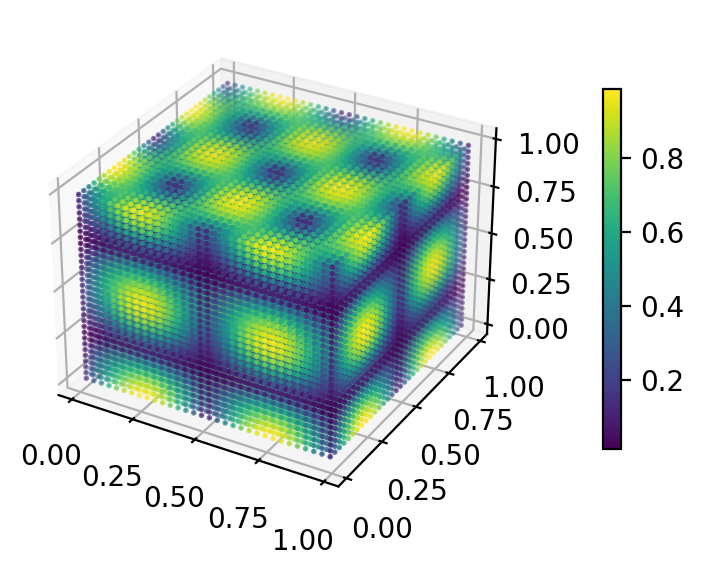

In [13]:
render(state)

In [14]:
iterstep_max = int(t_end / dt)

# compute loop until final time has been reached
for iterstep in range(iterstep_max):

    state, neighbors = advance(dt, state, neighbors, displacement_fn, shift_fn, kernel_fn, neighbor_fn, pressure_fn)
    
    # check if any particle has more neighbors than the maximum buffer size and if so, create a new list
    if neighbors.did_buffer_overflow:
        neighbors = neighbor_fn(state.r)

    # update the progress bar
    if (iterstep % 100 == 0): print(iterstep, '/', iterstep_max)

/local/disk1/share/opt/miniconda3-4.5.12/envs/neuralSPH/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:2929: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/local/disk1/share/opt/miniconda3-4.5.12/envs/neuralSPH/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3044: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in ones is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "ones")


0 / 1408
100 / 1408
200 / 1408
300 / 1408
400 / 1408
500 / 1408
600 / 1408
700 / 1408
800 / 1408
900 / 1408
1000 / 1408
1100 / 1408
1200 / 1408
1300 / 1408
1400 / 1408


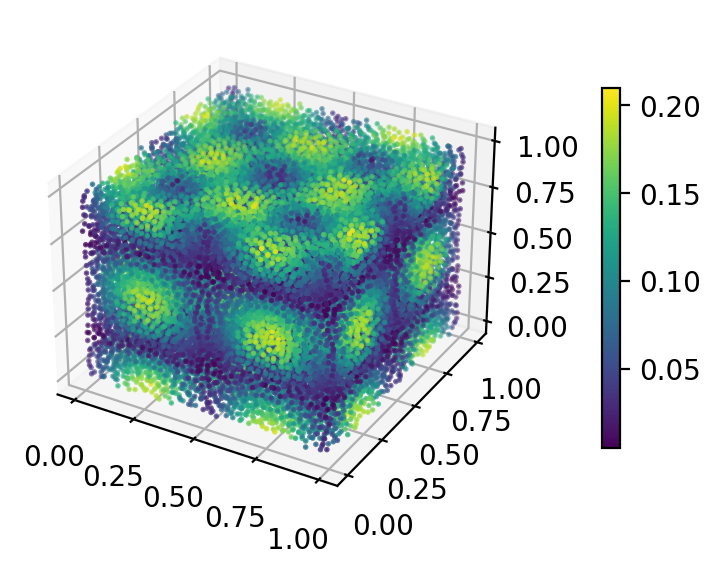

In [15]:
render(state)